In [ ]:
import numpy as np
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter

# Ensure reproducibility
np.random.seed(22)
tf.random.set_seed(22)

# Ensure directories exist
os.makedirs("./weights", exist_ok=True)
os.makedirs("./images", exist_ok=True)

# Data Loading and Visualization


In [5]:
# Load datasets
train = pd.read_json("./stanford-covid-vaccine/train.json", lines=True)
test = pd.read_json("./stanford-covid-vaccine/test.json", lines=True)
sub = pd.read_csv("./stanford-covid-vaccine/sample_submission.csv")

# Filter training data
train = train[train.signal_to_noise > 1].reset_index(drop=True)

# Separate public and private test data
test_pub = test[test["seq_length"] == 107].reset_index(drop=True)
test_pri = test[test["seq_length"] == 130].reset_index(drop=True)

# Dataset understanding - Exploratory Data Analysis (EDA)

## Distribution of sequence length

The training set contains exclusively sequences with a fixed length of **107 nucleotides**.  
This uniformity simplifies model input handling, as all features per position will have consistent dimensions across the dataset.

It is worth noting that longer sequences (e.g., length 130) appear only in the test set, which may require special handling during inference or model generalization.

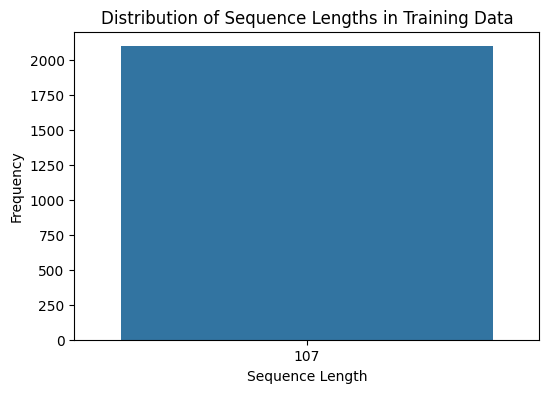

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=train["seq_length"])
plt.title("Distribution of Sequence Lengths in Training Data")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.savefig("./images/seq_length_distribution.png", bbox_inches="tight", dpi=200)

## Base frequency in sequences

This bar chart shows the overall frequency of each nucleotide across all RNA sequences in the training set.

- **Adenine (A)** is the most common nucleotide, appearing significantly more often than the others.
- **Uracil (U)** is the least frequent.
- The frequencies are not perfectly balanced, but all four bases (**A**, **C**, **G**, **U**) are well represented, which is important for the model to generalize across different sequence patterns.

This information can also be useful for potential sequence-based feature engineering, such as GC content or base pair probabilities.

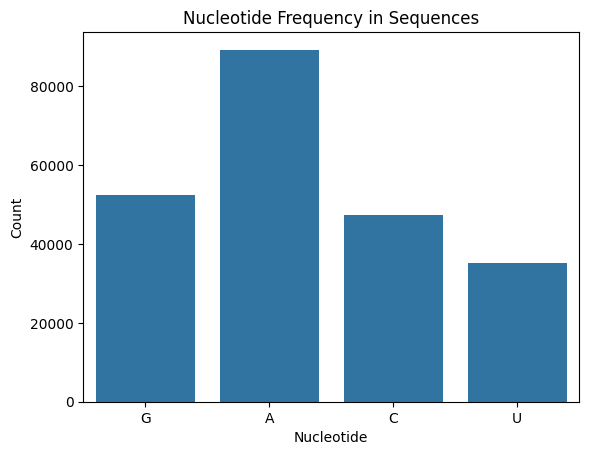

In [ ]:
all_bases = "".join(train["sequence"].values)
base_counts = Counter(all_bases)
sns.barplot(x=list(base_counts.keys()), y=list(base_counts.values()))
plt.title("Nucleotide Frequency in Sequences")
plt.xlabel("Nucleotide")
plt.ylabel("Count")
plt.savefig("./images/nucleotide_frequency.png", bbox_inches="tight", dpi=200)
plt.show()

## Frequency of RNA Structure Symbols

This chart illustrates the distribution of RNA secondary structure symbols found in the training set:

- **`.` (dot)** represents unpaired nucleotides (loops or single-stranded regions) and is by far the most frequent symbol.
- **`(` and `)`** indicate base pairs (forming stems), where `(` is the opening and `)` is the closing of a paired region. Their counts are nearly identical, as expected from valid base-pair matching.

The predominance of unpaired regions suggests that most positions in the RNA sequences are located in loop or non-helical regions. This distribution may impact model performance, especially in tasks sensitive to secondary structure.


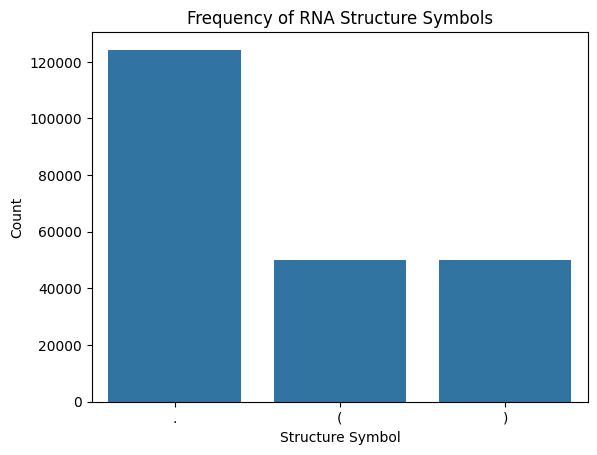

In [ ]:
all_structs = "".join(train["structure"].values)
struct_counts = Counter(all_structs)
sns.barplot(x=list(struct_counts.keys()), y=list(struct_counts.values()))
plt.title("Frequency of RNA Structure Symbols")
plt.xlabel("Structure Symbol")
plt.ylabel("Count")
plt.savefig("./images/structure_symbol_frequency.png", bbox_inches="tight", dpi=200)
plt.show()

## Frequency of Predicted Loop Types

This plot shows the distribution of predicted loop types across all sequences:

- **S (Stem)** and **E (Exterior loop)** are by far the most frequent structural contexts, indicating a dominance of base-paired regions and outer loop positions.
- **H (Hairpin loop)** appears with moderate frequency and is biologically significant for RNA stability and function.
- Less common loop types such as **B (Bulge)**, **I (Internal loop)**, **M (Multi-loop)** and **X (Other/Unclassified)** are present but sparse.

The unbalanced distribution suggests the model may be biased towards the more frequent structural motifs unless specifically regularized or weighted during training.


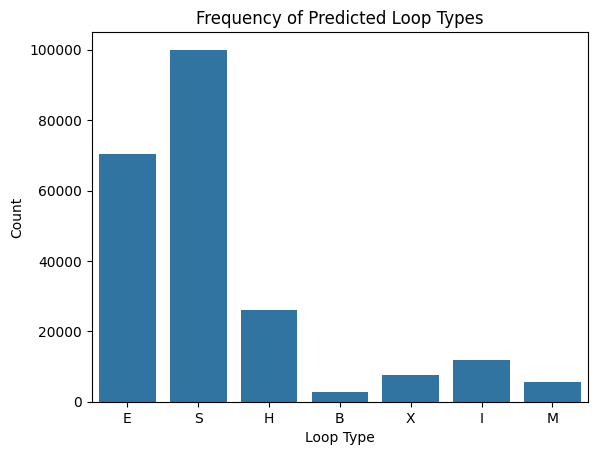

In [ ]:
all_loops = "".join(train["predicted_loop_type"].values)
loop_counts = Counter(all_loops)
sns.barplot(x=list(loop_counts.keys()), y=list(loop_counts.values()))
plt.title("Frequency of Predicted Loop Types")
plt.xlabel("Loop Type")
plt.ylabel("Count")
plt.savefig("./images/loop_type_frequency.png", bbox_inches="tight", dpi=200)
plt.show()

### Violin distribution of Reactivity by Loop Type

This violin plot illustrates the distribution of **reactivity values** across the different predicted loop types.

Key observations:

- **Hairpin (H)**, **Internal (I)** and **Multi-loops (M)** tend to exhibit slightly higher reactivity variability, which aligns with their biological flexibility.
- **Stems (S)** and **Exteriors (E)** show tighter, lower distributions — expected since stems are usually base-paired and more structurally constrained.
- Outliers and high-reactivity tails are visible in several loop types, particularly in **Hairpin** and **Bulge (B)** regions.
- Negative values may indicate noise or artefacts, and could merit preprocessing (e.g., clipping or filtering) before training.

This plot reinforces that **loop type is a strong contextual feature** and should be considered as an input for the model.


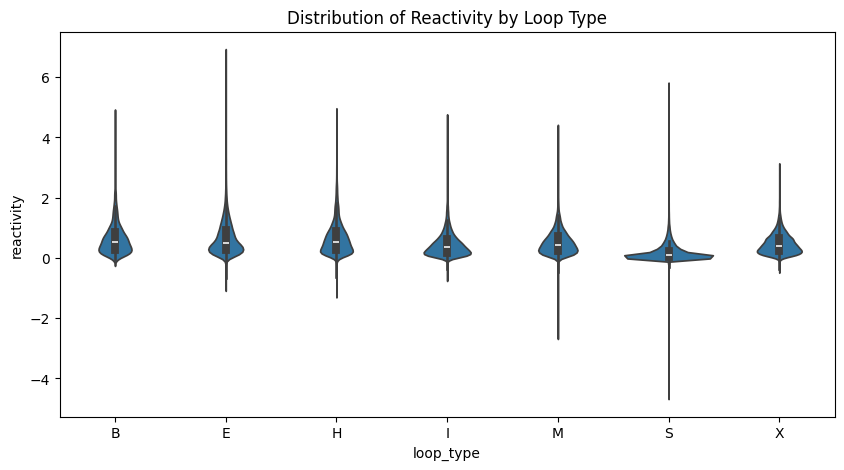

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
long_data = []
for i, row in train.iterrows():
    for j in range(len(row["reactivity"])):
        long_data.append({
            "loop_type": row["predicted_loop_type"][j],
            "reactivity": row["reactivity"][j]
        })
df_long = pd.DataFrame(long_data)

# Plot
plt.figure(figsize=(10, 5))
sns.violinplot(data=df_long, x="loop_type", y="reactivity", order=sorted(df_long["loop_type"].unique()))
plt.title("Distribution of Reactivity by Loop Type")
plt.savefig("./images/reactivity_by_loop_type.png", bbox_inches="tight", dpi=200)
plt.show()

## Signal-to-Noise Ratio Distribution

This plot shows the distribution of the **signal-to-noise ratio** in the training set.

Observations:
- The distribution is **right-skewed**, with most sequences concentrated between **3 and 7**.
- A small number of sequences have much higher signal-to-noise ratios (above 10), which might represent high-confidence experimental measurements.
- The minimum is slightly above **1**, consistent with the filtering applied earlier in the notebook (`signal_to_noise > 1`).

This variable is crucial for training, as **higher signal-to-noise ratios typically yield more reliable target values** (e.g., `reactivity`). It may be used as a weighting factor or to stratify data splits for training and validation.


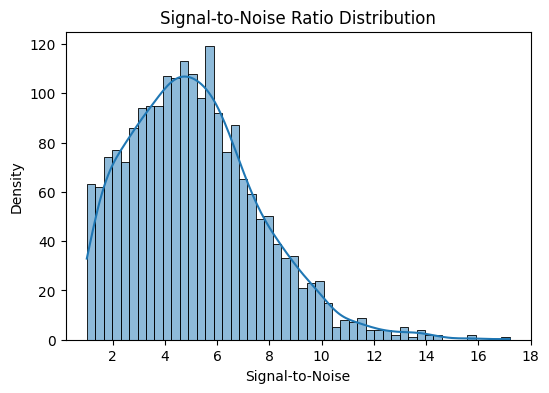

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(train["signal_to_noise"], bins=50, kde=True)
plt.title("Signal-to-Noise Ratio Distribution")
plt.xlabel("Signal-to-Noise")
plt.ylabel("Density")
plt.savefig("./images/signal_to_noise_distribution.png", bbox_inches="tight", dpi=200)
plt.show()

## Distribution of Target Variables

This set of histograms shows the distribution of all five regression targets present in the training data:

- **All target variables exhibit strong right-skewness**, with the majority of values concentrated near zero and long positive tails.
- Some negative values are present across all variables. These may stem from measurement noise or normalization artifacts and should be considered when preprocessing the targets (e.g., clipping or transformation).
- The **`reactivity`** values are denser around the 0.5–1.5 range, suggesting it carries higher absolute values than the degradation metrics.
- Degradation targets such as **`deg_Mg_pH10`**, **`deg_Mg_50C`**, and **`deg_50C`** show similar patterns, which might indicate redundancy or collinearity.

This analysis suggests that modeling these outputs may benefit from:
- Robust loss functions (e.g., Huber)
- Normalization or log-transformation
- Outlier handling


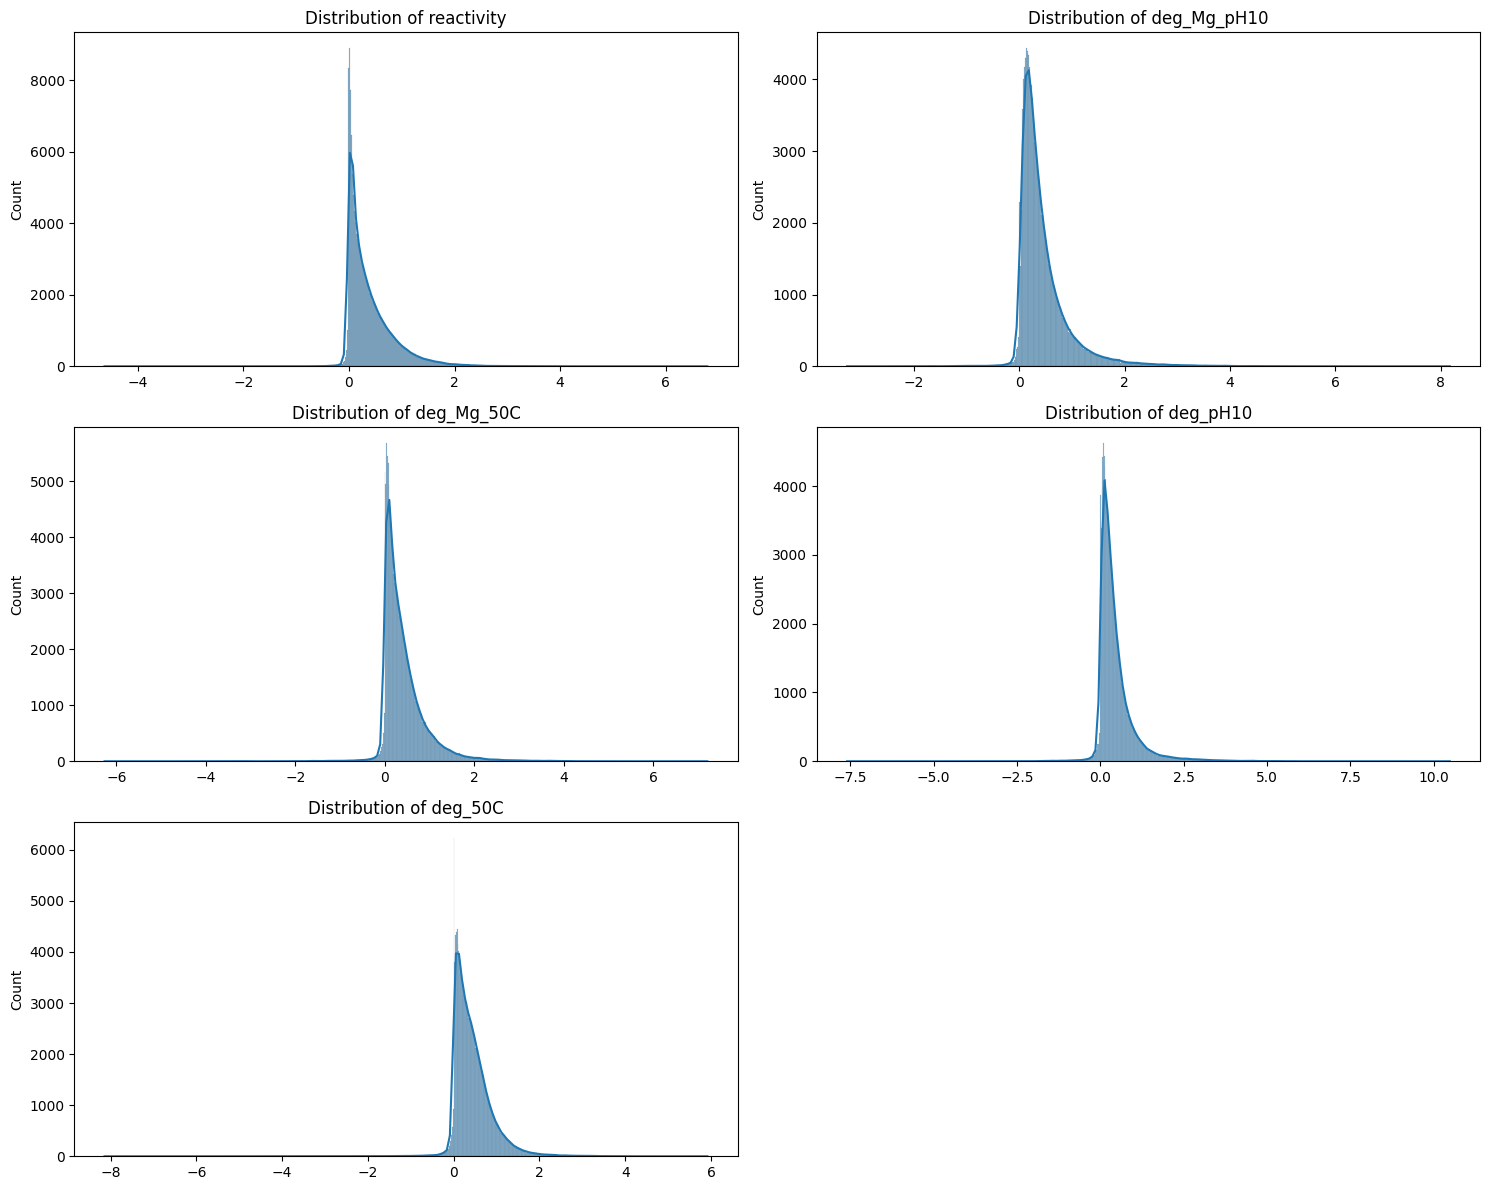

In [ ]:
targets = ["reactivity", "deg_Mg_pH10", "deg_Mg_50C", "deg_pH10", "deg_50C"]
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
for i, target in enumerate(targets):
    ax = axes[i // 2, i % 2]
    sns.histplot(np.concatenate(train[target]), ax=ax, kde=True)
    ax.set_title(f"Distribution of {target}")
fig.delaxes(axes[2, 1])
plt.tight_layout()
plt.savefig("./images/target_distributions.png", bbox_inches="tight", dpi=200)
plt.show()

## Mean Reactivity by Position

This line plot displays the **mean reactivity value per nucleotide position**, aggregated over all sequences in the training set. The shaded region represents the standard deviation at each position.

Observations:
- The **first few positions (especially position 0)** show significantly higher reactivity on average, along with higher variance. This might be due to boundary effects, structural exposure, or experimental noise.
- After position ~10, reactivity stabilizes around **0.4–0.6**, with a relatively narrow variance band.
- A slight increase in variance is observed again around position 30–40, possibly reflecting structural variability or loop transitions in RNA folds.

These patterns suggest that **positional encoding** or **attention to early positions** could be valuable in model design, especially if certain regions carry more structural or functional signal.


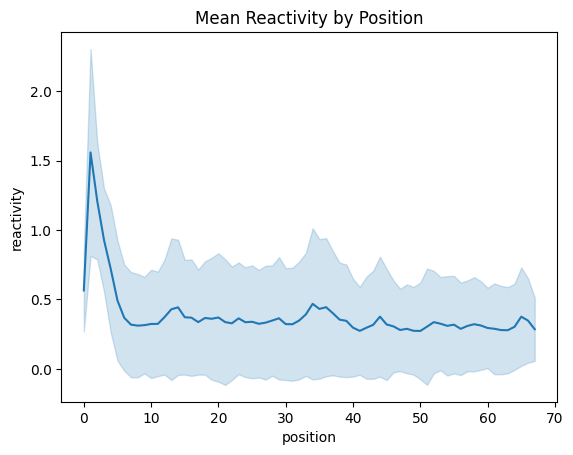

In [ ]:
# Efficient and safe construction of train_long
long_data = []
for i, row in train.iterrows():
    seq_len = min(len(row["reactivity"]), len(row["predicted_loop_type"]))
    for j in range(seq_len):
        long_data.append({
            "id": row["id"],
            "position": j,
            "reactivity": row["reactivity"][j],
            "loop_type": row["predicted_loop_type"][j]
        })
train_long = pd.DataFrame(long_data)

# Plot reactivity vs position
sns.lineplot(data=train_long, x="position", y="reactivity", errorbar='sd')
plt.title("Mean Reactivity by Position")
plt.savefig("./images/mean_reactivity_by_position.png", bbox_inches="tight", dpi=200)
plt.show()


## Correlation Matrix of Target Variables

This heatmap displays the **Pearson correlation coefficients** between the five target variables, where each row represents a nucleotide position (not a full sequence).

Insights:
- **High correlation** is observed among the degradation metrics, particularly:
  - `deg_Mg_pH10` ↔ `deg_Mg_50C`: **0.86**
  - `deg_Mg_50C` ↔ `deg_50C`: **0.82**
  - `deg_pH10` also strongly correlates with others (≥ 0.74)
- **`Reactivity` shows moderate correlation** (0.56–0.65) with the degradation targets, which is expected, as it reflects local RNA flexibility rather than degradation rate directly.

These results suggest that some targets may contain **redundant information**, which:
- Can be leveraged via **multi-task learning**,
- Or decorrelated via **dimensionality reduction** if needed.

Understanding these interdependencies is crucial for choosing model architectures and output handling strategies.


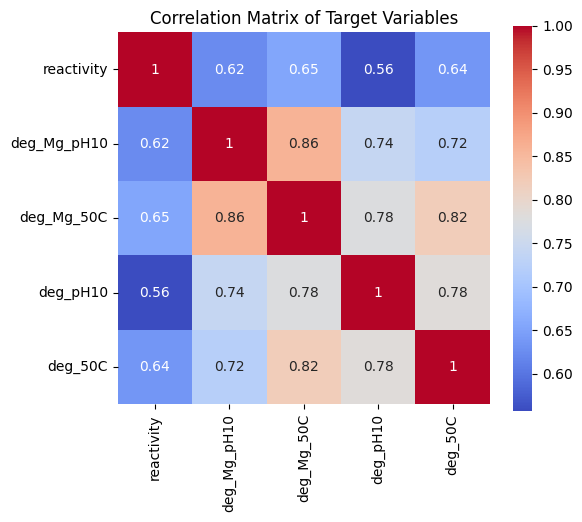

In [ ]:
# Flatten the target columns so each row is a position, not a sequence
flat_targets = pd.DataFrame(
    {target: np.concatenate(train[target].values) for target in targets}
)

plt.figure(figsize=(6, 5))
sns.heatmap(flat_targets.corr(),
            annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Target Variables")
plt.savefig("./images/target_correlation_matrix.png", bbox_inches="tight", dpi=200)
plt.show()

# Feature Engineering


In [5]:
# Load BPP matrices
def load_bpps(df, path="../../stanford-covid-vaccine/bpps/"):
    bpps = []
    for id_val in tqdm(df["id"], desc="Loading BPPs"):
        bpps.append(np.load(f"{path}{id_val}.npy"))
    return np.array(bpps)


As = load_bpps(train)
As_pub = load_bpps(test_pub)
As_pri = load_bpps(test_pri)

# Prepare y_train
seq_len_train_example = train["seq_length"].iloc[0]
seq_len_target_example = train["seq_scored"].iloc[0]
ignore_value = -10000
ignore_length = seq_len_train_example - seq_len_target_example

y_train = []
for target in targets:
    y = np.vstack(train[target])
    dummy = np.zeros([y.shape[0], ignore_length]) + ignore_value
    y = np.hstack([y, dummy])
    y_train.append(y)
y = np.stack(y_train, axis=2)

Loading BPPs:   0%|          | 0/2096 [00:00<?, ?it/s]

Loading BPPs:   0%|          | 0/629 [00:00<?, ?it/s]

Loading BPPs:   0%|          | 0/3005 [00:00<?, ?it/s]

Structure Adjacency:   0%|          | 0/2096 [00:00<?, ?it/s]

Structure Adjacency:   0%|          | 0/629 [00:00<?, ?it/s]

Structure Adjacency:   0%|          | 0/3005 [00:00<?, ?it/s]

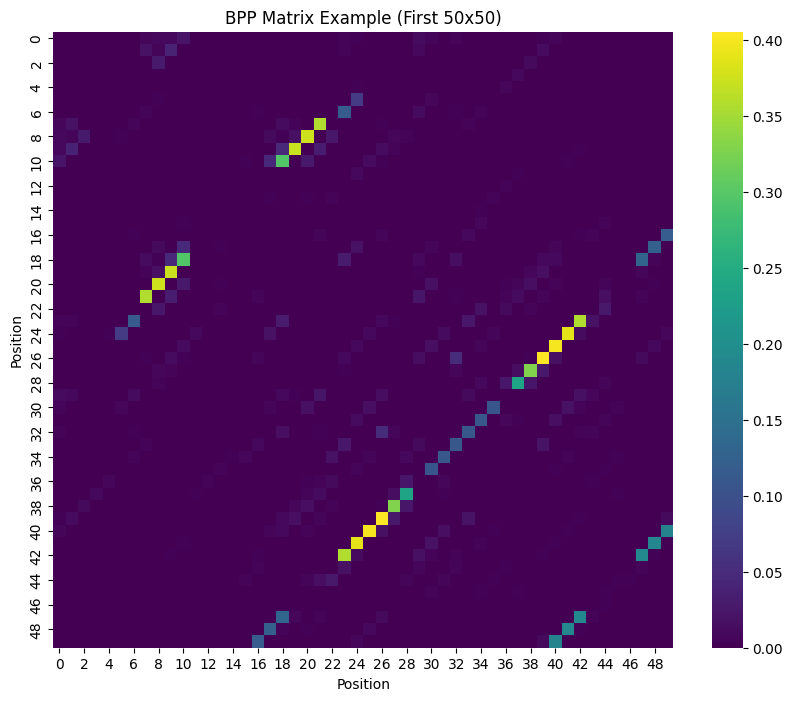

10006

In [6]:
def get_structure_adj(df):
    Ss = []
    for i in tqdm(range(len(df)), desc="Structure Adjacency"):
        seq_length = df["seq_length"].iloc[i]
        structure = df["structure"].iloc[i]
        sequence = df["sequence"].iloc[i]

        a_structures = {
            ("A", "U"): np.zeros([seq_length, seq_length]),
            ("C", "G"): np.zeros([seq_length, seq_length]),
            ("U", "G"): np.zeros([seq_length, seq_length]),
            ("U", "A"): np.zeros([seq_length, seq_length]),
            ("G", "C"): np.zeros([seq_length, seq_length]),
            ("G", "U"): np.zeros([seq_length, seq_length]),
        }

        cue = []
        for j in range(seq_length):
            if structure[j] == "(":
                cue.append(j)
            elif structure[j] == ")":
                if cue:
                    start = cue.pop()
                    a_structures[(sequence[start], sequence[j])][start, j] = 1
                    a_structures[(sequence[j], sequence[start])][j, start] = 1

        a_strc = np.stack(list(a_structures.values()), axis=2)
        a_strc = np.sum(a_strc, axis=2, keepdims=True)
        Ss.append(a_strc)

    return np.array(Ss)


Ss = get_structure_adj(train)
Ss_pub = get_structure_adj(test_pub)
Ss_pri = get_structure_adj(test_pri)


def get_distance_matrix(bpps_array):
    seq_length = bpps_array.shape[1]
    idx = np.arange(seq_length)
    Ds = []
    for i in range(seq_length):
        d = np.abs(idx[i] - idx)
        Ds.append(d)

    Ds = np.array(Ds) + 1
    Ds = 1 / Ds
    Ds = Ds[None, :, :]
    Ds = np.repeat(Ds, len(bpps_array), axis=0)

    Dss = []
    for i in [1, 2, 4]:
        Dss.append(Ds**i)
    Ds = np.stack(Dss, axis=3)
    return Ds


Ds = get_distance_matrix(As)
Ds_pub = get_distance_matrix(As_pub)
Ds_pri = get_distance_matrix(As_pri)

# Combine adjacency features
As = np.concatenate([As[:, :, :, None], Ss, Ds], axis=3).astype(np.float32)
As_pub = np.concatenate([As_pub[:, :, :, None], Ss_pub, Ds_pub], axis=3).astype(
    np.float32
)
As_pri = np.concatenate([As_pri[:, :, :, None], Ss_pri, Ds_pri], axis=3).astype(
    np.float32
)

# Visualize adjacency matrix
plt.figure(figsize=(10, 8))
sns.heatmap(As[0][:50, :50, 0], cmap="viridis")
plt.title("BPP Matrix Example (First 50x50)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.savefig("./images/bpp_matrix.png", bbox_inches="tight")
plt.show()

# Free memory
del Ss, Ds, Ss_pub, Ds_pub, Ss_pri, Ds_pri
gc.collect()

In [7]:
def return_ohe(n, i):
    return [1 if j == i else 0 for j in range(n)]


def get_input(df):
    # Sequence encoding
    mapping_node = {s: return_ohe(4, i) for i, s in enumerate(["A", "G", "C", "U"])}
    X_node = np.stack(df["sequence"].apply(lambda x: [mapping_node[y] for y in x]))

    # Loop type encoding
    mapping_loop = {
        s: return_ohe(7, i) for i, s in enumerate(["S", "M", "I", "B", "H", "E", "X"])
    }
    X_loop = np.stack(
        df["predicted_loop_type"].apply(lambda x: [mapping_loop[y] for y in x])
    )

    X_node = np.concatenate([X_node, X_loop], axis=2)

    # Interaction features
    a = np.sum(X_node * (2 ** np.arange(X_node.shape[2])[None, None, :]), axis=2)
    vocab = sorted(set(a.flatten()))
    ohes = np.stack([(a == v).astype(float) for v in vocab], axis=2)

    return np.concatenate([X_node, ohes], axis=2).astype(np.float32)


X_node = get_input(train)
X_node_pub = get_input(test_pub)
X_node_pri = get_input(test_pri)

# Model Architecture


In [8]:
def mcrmse(t, p, seq_len_target):
    t = t[:, :seq_len_target]
    p = p[:, :seq_len_target]
    score = np.mean(np.sqrt(np.mean(np.mean((p - t) ** 2, axis=1), axis=0)))
    return score


def mcrmse_loss(t, y, seq_len_target):
    t = t[:, :seq_len_target]
    y = y[:, :seq_len_target]
    loss = tf.reduce_mean(
        tf.sqrt(tf.reduce_mean(tf.reduce_mean((t - y) ** 2, axis=1), axis=0))
    )
    return loss

In [9]:
class AutoencoderLossLayer(L.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        node, p = inputs
        loss = -tf.reduce_mean(
            20 * node * tf.math.log(p + 1e-4) + (1 - node) * tf.math.log(1 - p + 1e-4)
        )
        return loss

In [10]:
def attention(x_inner, x_outer, n_factor):
    x_Q = L.Conv1D(
        n_factor,
        1,
        activation="linear",
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform",
    )(x_inner)
    x_K = L.Conv1D(
        n_factor,
        1,
        activation="linear",
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform",
    )(x_outer)
    x_V = L.Conv1D(
        n_factor,
        1,
        activation="linear",
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform",
    )(x_outer)
    x_KT = L.Permute((2, 1))(x_K)
    res = L.Lambda(lambda c: K.batch_dot(c[0], c[1]) / np.sqrt(n_factor))([x_Q, x_KT])
    att = L.Lambda(lambda c: K.softmax(c, axis=-1))(res)
    att = L.Lambda(lambda c: K.batch_dot(c[0], c[1]))([att, x_V])
    return att


def multi_head_attention(x, y, n_factor, n_head, dropout):
    if n_head == 1:
        att = attention(x, y, n_factor)
    else:
        n_factor_head = n_factor // n_head
        heads = [attention(x, y, n_factor_head) for _ in range(n_head)]
        att = L.Concatenate()(heads)
        att = L.Dense(n_factor, kernel_initializer="glorot_uniform")(att)
    x = L.Add()([x, att])
    x = L.LayerNormalization()(x)
    if dropout > 0:
        x = L.Dropout(dropout)(x)
    return x


def res(x, unit, kernel=3, rate=0.2):
    h = L.Conv1D(unit, kernel, 1, padding="same", activation=None)(x)
    h = L.LayerNormalization()(h)
    h = L.LeakyReLU()(h)
    h = L.Dropout(rate)(h)
    return L.Add()([x, h])


def forward(x, unit, kernel=3, rate=0.2):
    h = L.Conv1D(unit, kernel, 1, padding="same", activation=None)(x)
    h = L.LayerNormalization()(h)
    h = L.Dropout(rate)(h)
    h = L.LeakyReLU()(h)
    h = res(h, unit, kernel, rate)
    return h


def adj_attn(x, adj, unit, n=2, rate=0.2):
    x_a = x
    x_as = []
    for _ in range(n):
        x_a = forward(x_a, unit)
        x_a = L.Lambda(lambda inputs: tf.matmul(inputs[0], inputs[1]))([adj, x_a])
        x_as.append(x_a)
    if n == 1:
        x_a = x_as[0]
    else:
        x_a = L.Concatenate()(x_as)
    x_a = forward(x_a, unit)
    return x_a

In [11]:
def get_base(X_node_shape_2, As_shape_3):
    node = tf.keras.Input(shape=(None, X_node_shape_2), name="node")
    adj = tf.keras.Input(shape=(None, None, As_shape_3), name="adj")

    # Learnable adjacency component
    adj_learned = L.Dense(1, "relu")(adj)
    adj_all = L.Concatenate(axis=3)([adj, adj_learned])

    # Feature extraction
    xs = []
    xs.append(node)
    x1 = forward(node, 128, kernel=3, rate=0.2)
    x2 = forward(x1, 96, kernel=6, rate=0.2)
    x3 = forward(x2, 64, kernel=15, rate=0.2)
    x4 = forward(x3, 32, kernel=30, rate=0.2)
    x = L.Concatenate()([x1, x2, x3, x4])

    # Graph convolution and attention
    for unit in [128, 64]:
        x_as = []
        for i in range(adj_all.shape[3]):
            adj_slice = L.Lambda(lambda inputs, idx=i: inputs[:, :, :, idx])(adj_all)
            x_a = adj_attn(x, adj_slice, unit, rate=0.2)
            x_as.append(x_a)
        x_c = forward(x, unit, kernel=30, rate=0.2)

        x = L.Concatenate()(x_as + [x_c])
        x = forward(x, unit, rate=0.2)
        x = multi_head_attention(x, x, unit, 8, 0.2)
        xs.append(x)

    x = L.Concatenate()(xs)
    return tf.keras.Model(inputs=[node, adj], outputs=x)


def get_ae_model(base_model, X_node_shape_2):
    node = tf.keras.Input(shape=(None, X_node_shape_2), name="node")
    adj = tf.keras.Input(shape=(None, None, base_model.input[1].shape[3]), name="adj")

    x = base_model([L.SpatialDropout1D(0.4)(node), adj])
    x = L.Dense(
        128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = L.Dropout(0.4)(x)
    x = L.BatchNormalization()(x)
    p = L.Dense(X_node_shape_2, activation="sigmoid")(x)

    loss = AutoencoderLossLayer()([node, p])
    model = tf.keras.Model(inputs=[node, adj], outputs=[loss])

    opt = tf.optimizers.Adam()
    model.compile(optimizer=opt, loss=lambda _, y: y)
    return model


def get_model(base_model, seq_len_target, As_shape_3):
    node = tf.keras.Input(shape=(None, base_model.input[0].shape[2]), name="node")
    adj = tf.keras.Input(shape=(None, None, As_shape_3), name="adj")

    x = base_model([node, adj])
    x = L.Dense(
        256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = L.Dropout(0.5)(x)
    x = L.BatchNormalization()(x)
    x = L.Dense(5, activation=None)(x)

    model = tf.keras.Model(inputs=[node, adj], outputs=[x])
    opt = tf.optimizers.Adam()
    model.compile(optimizer=opt, loss=lambda t, y: mcrmse_loss(t, y, seq_len_target))
    return model

# Model Training


In [12]:
base_model_ae = get_base(X_node.shape[2], As.shape[3])
ae_model = get_ae_model(base_model_ae, X_node.shape[2])

# Training data
dummy_ae_target = np.zeros_like(X_node[:, :, 0])
dummy_ae_target_pub = np.zeros_like(X_node_pub[:, :, 0])
dummy_ae_target_pri = np.zeros_like(X_node_pri[:, :, 0])

# Pre-training schedule
for i in range(3):
    print(f"Pre-training Iteration {i+1}/3")
    ae_model.fit([X_node, As], [dummy_ae_target], epochs=5, batch_size=32, verbose=1)
    ae_model.fit(
        [X_node_pub, As_pub], [dummy_ae_target_pub], epochs=2, batch_size=32, verbose=1
    )
    ae_model.fit(
        [X_node_pri, As_pri], [dummy_ae_target_pri], epochs=2, batch_size=32, verbose=1
    )
    gc.collect()

base_model_ae.save_weights("./weights/base_ae.weights.h5")

Pre-training Iteration 1/3
Epoch 1/5
66/66 [==============================] - 33s 140ms/step - loss: 1.9844
Epoch 2/5
66/66 [==============================] - 8s 115ms/step - loss: 0.7375
Epoch 3/5
66/66 [==============================] - 8s 115ms/step - loss: 0.3039
Epoch 4/5
66/66 [==============================] - 8s 117ms/step - loss: 0.1659
Epoch 5/5
66/66 [==============================] - 8s 117ms/step - loss: 0.1134
Epoch 1/2
20/20 [==============================] - 4s 202ms/step - loss: 0.1009
Epoch 2/2
20/20 [==============================] - 2s 117ms/step - loss: 0.0912
Epoch 1/2
94/94 [==============================] - 26s 141ms/step - loss: 0.0906
Epoch 2/2
94/94 [==============================] - 12s 132ms/step - loss: 0.0884
Pre-training Iteration 2/3
Epoch 1/5
66/66 [==============================] - 8s 120ms/step - loss: 0.0680
Epoch 2/5
66/66 [==============================] - 8s 121ms/step - loss: 0.0562
Epoch 3/5
66/66 [==============================] - 8s 120ms/ste

Fold 0 training
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node (InputLayer)              [(None, None, 39)]   0           []                               
                                                                                                  
 adj (InputLayer)               [(None, None, None,  0           []                               
                                 5)]                                                              
                                                                                                  
 model_2 (Functional)           (None, None, 231)    6224006     ['node[0][0]',                   
                                                                  'adj[0][0]']                    
                                                                            

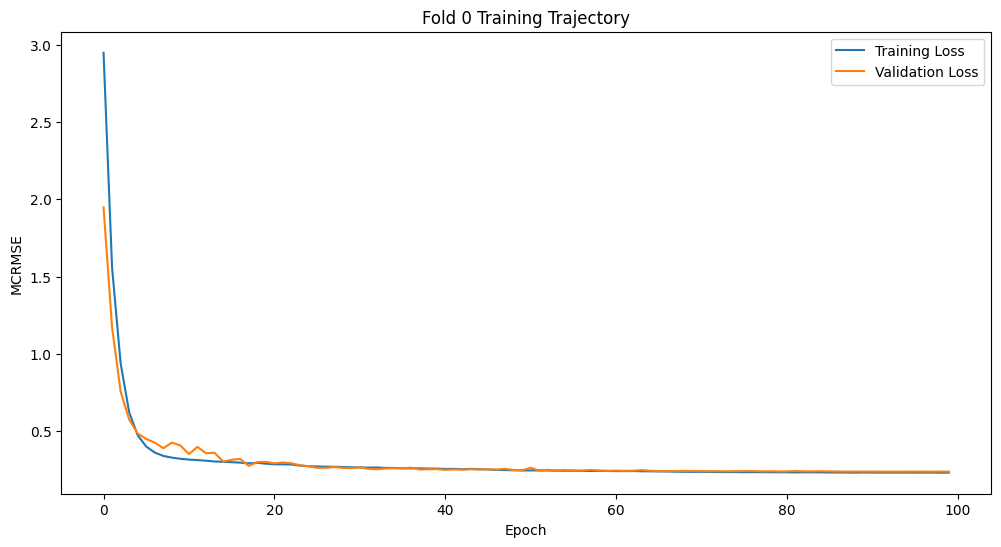

Fold 0: MCRMSE 0.23817530064887552

Validation Metrics:
reactivity_rmse: 0.2100
reactivity_r2: 0.7727
deg_Mg_pH10_rmse: 0.2587
deg_Mg_pH10_r2: 0.7524
deg_pH10_rmse: 0.2621
deg_pH10_r2: 0.8109
deg_Mg_50C_rmse: 0.2266
deg_Mg_50C_r2: 0.8047
deg_50C_rmse: 0.2335
deg_50C_r2: 0.7489


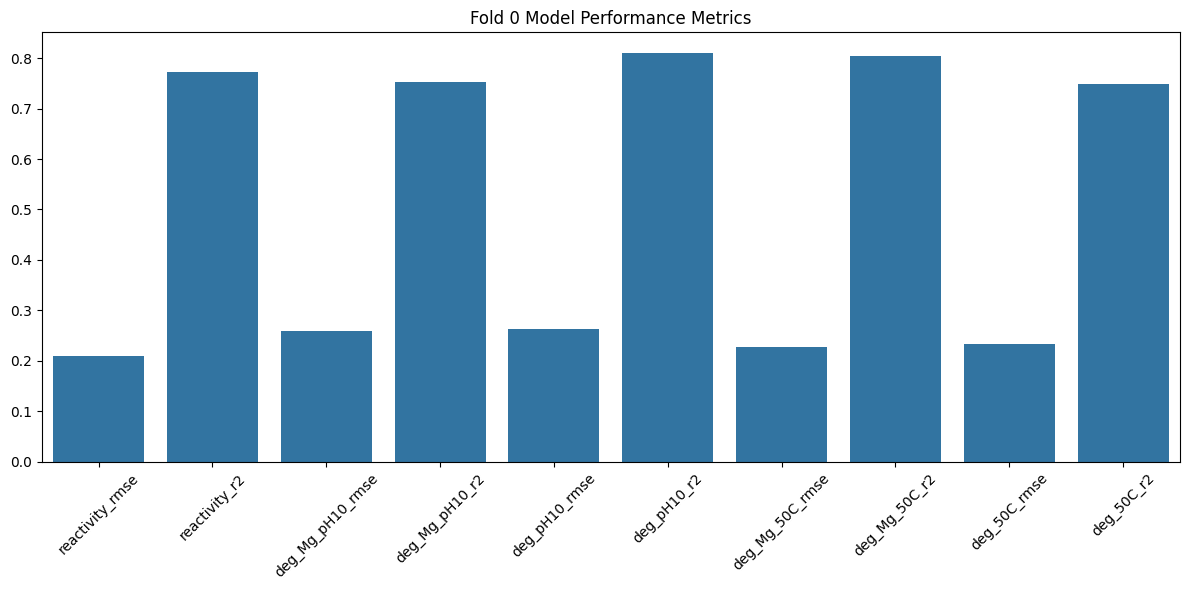

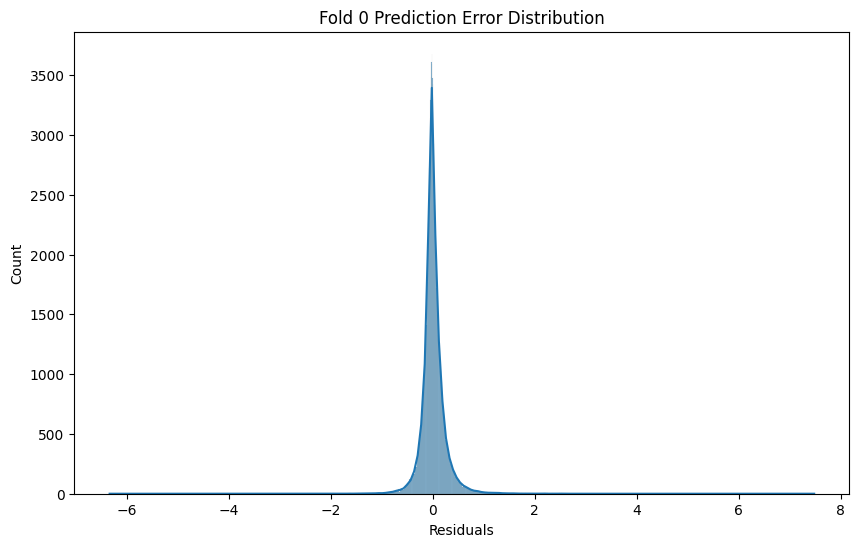

C:\Users\mateu\AppData\Local\Temp\ipykernel_16040\3234836794.py:103: RuntimeWarning: Mean of empty slice
  positional_errors = np.nanmean(np.abs(residuals), axis=(0, 2))


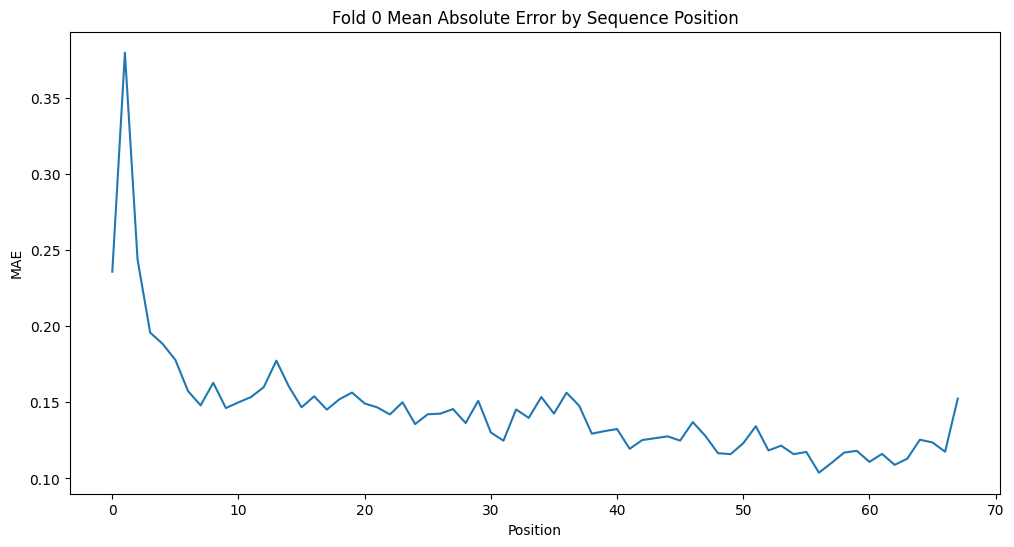

Fold 1 training
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node (InputLayer)              [(None, None, 39)]   0           []                               
                                                                                                  
 adj (InputLayer)               [(None, None, None,  0           []                               
                                 5)]                                                              
                                                                                                  
 model_4 (Functional)           (None, None, 231)    6224006     ['node[0][0]',                   
                                                                  'adj[0][0]']                    
                                                                            

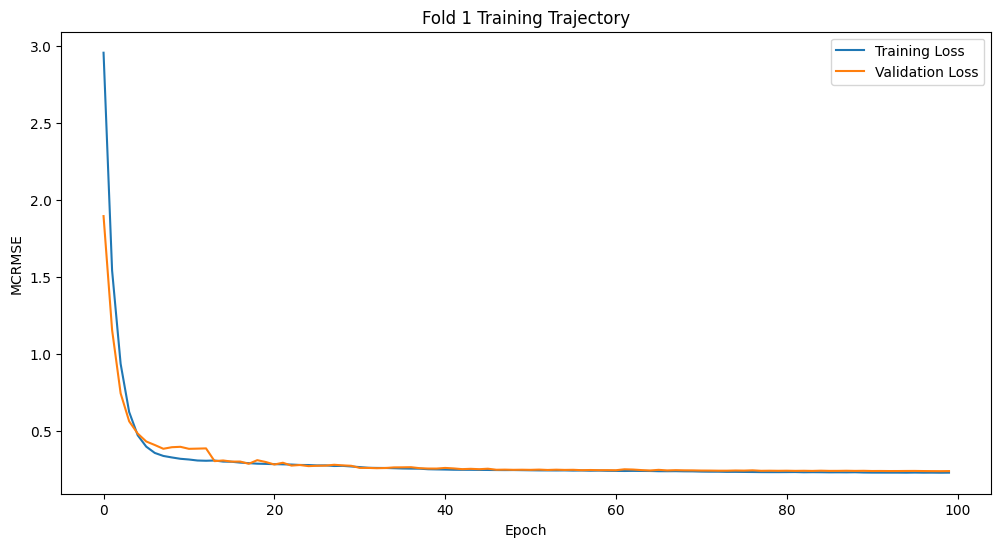

Fold 1: MCRMSE 0.24122247299328814

Validation Metrics:
reactivity_rmse: 0.2140
reactivity_r2: 0.7635
deg_Mg_pH10_rmse: 0.2532
deg_Mg_pH10_r2: 0.7459
deg_pH10_rmse: 0.2670
deg_pH10_r2: 0.7948
deg_Mg_50C_rmse: 0.2314
deg_Mg_50C_r2: 0.7851
deg_50C_rmse: 0.2405
deg_50C_r2: 0.7138


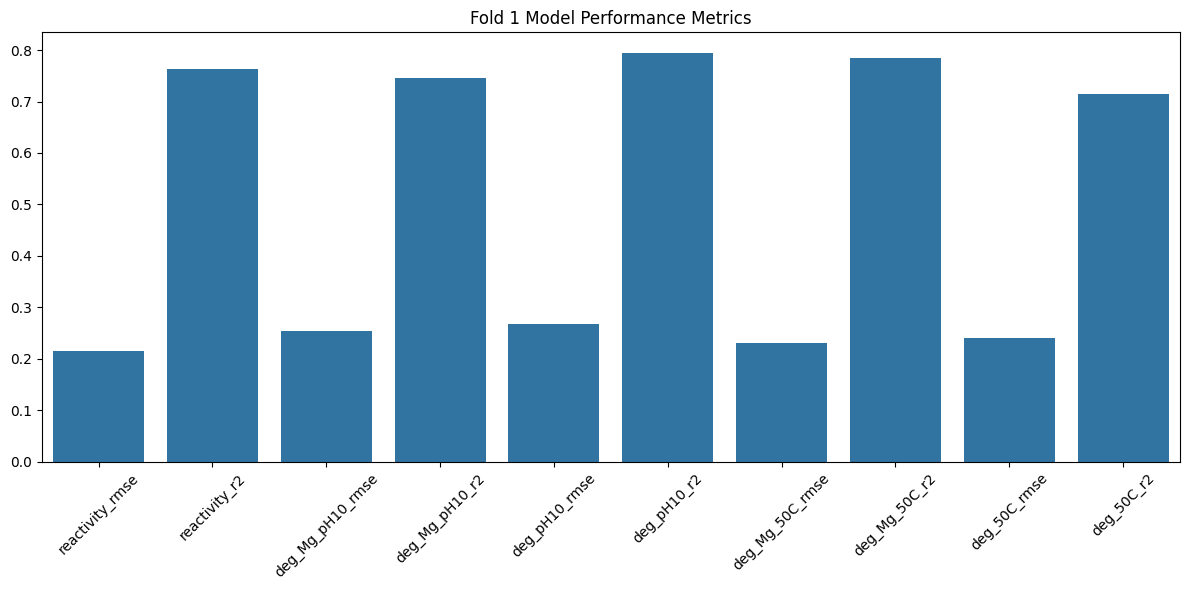

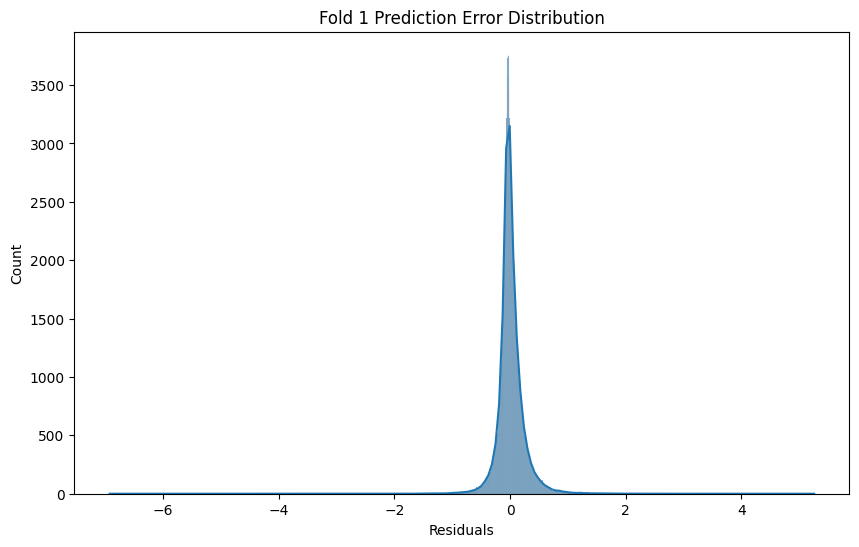

C:\Users\mateu\AppData\Local\Temp\ipykernel_16040\3234836794.py:103: RuntimeWarning: Mean of empty slice
  positional_errors = np.nanmean(np.abs(residuals), axis=(0, 2))


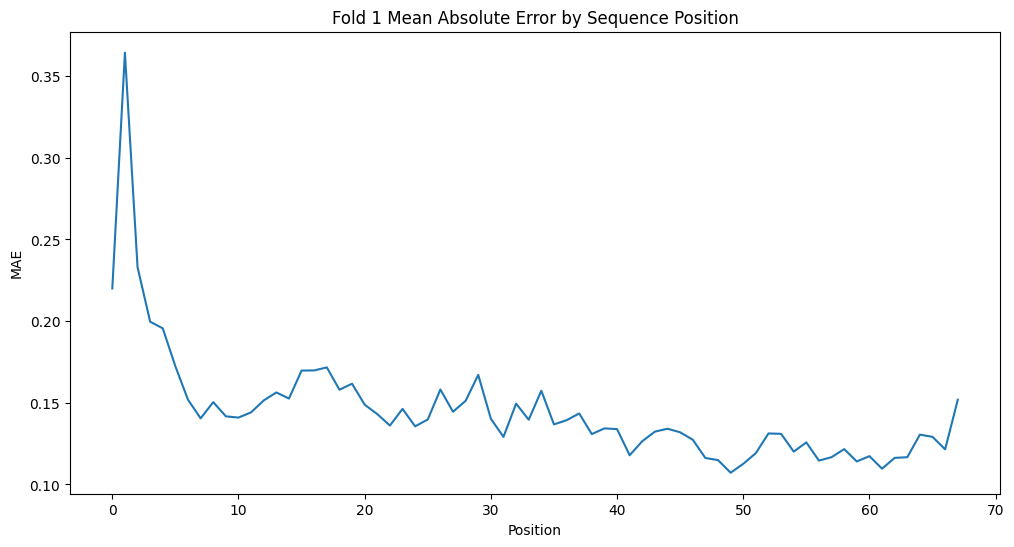

Fold 2 training
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node (InputLayer)              [(None, None, 39)]   0           []                               
                                                                                                  
 adj (InputLayer)               [(None, None, None,  0           []                               
                                 5)]                                                              
                                                                                                  
 model_6 (Functional)           (None, None, 231)    6224006     ['node[0][0]',                   
                                                                  'adj[0][0]']                    
                                                                            

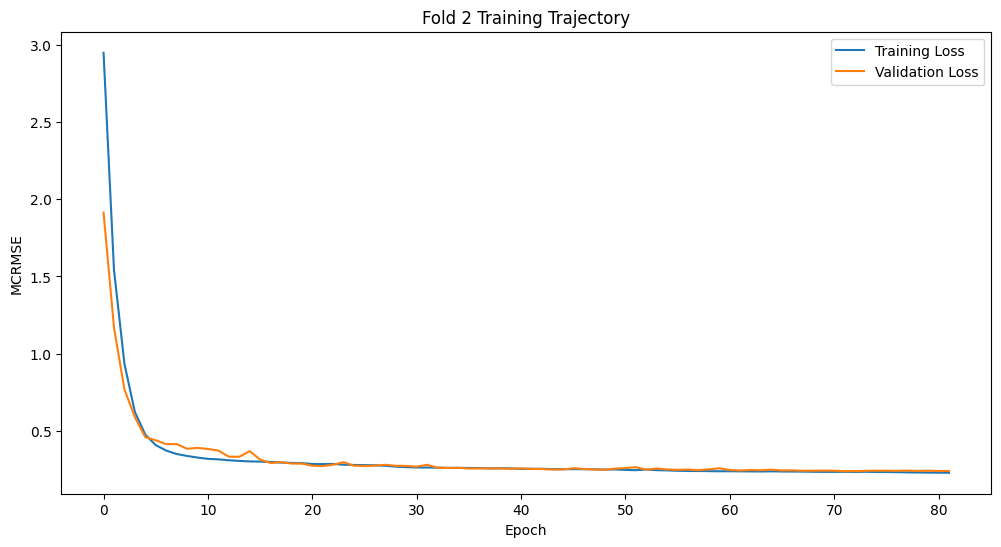

Fold 2: MCRMSE 0.23850023215084554

Validation Metrics:
reactivity_rmse: 0.2233
reactivity_r2: 0.7546
deg_Mg_pH10_rmse: 0.2526
deg_Mg_pH10_r2: 0.7588
deg_pH10_rmse: 0.2664
deg_pH10_r2: 0.8067
deg_Mg_50C_rmse: 0.2209
deg_Mg_50C_r2: 0.8102
deg_50C_rmse: 0.2293
deg_50C_r2: 0.7447


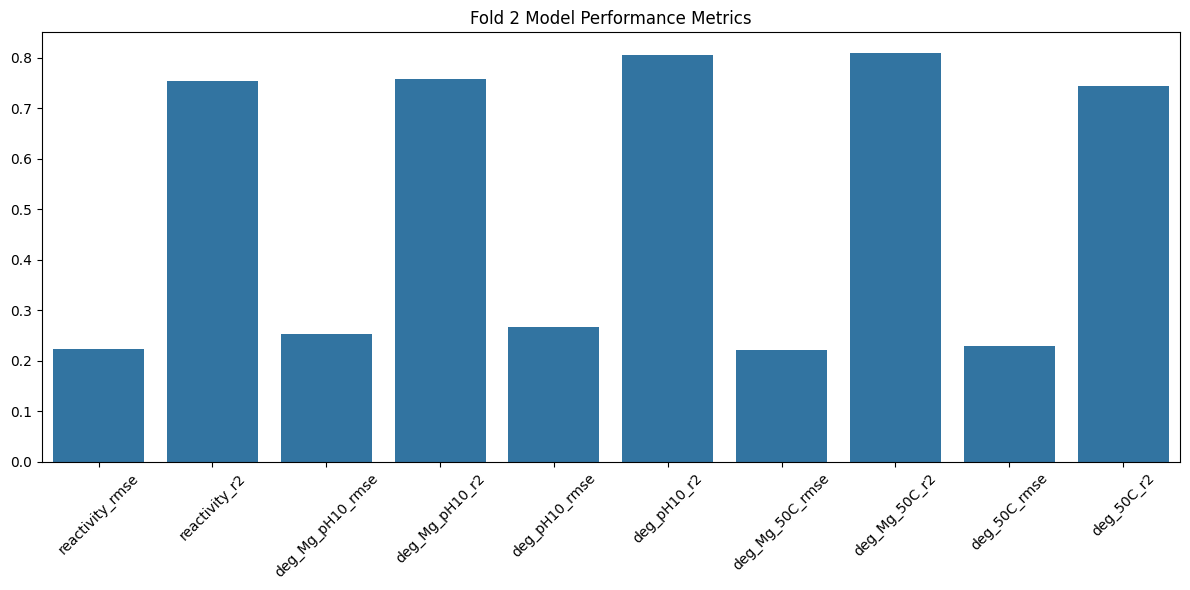

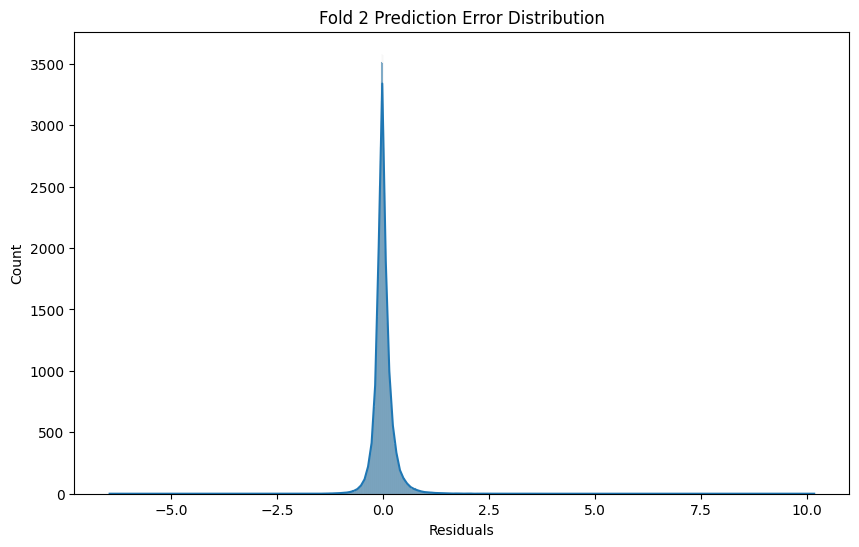

C:\Users\mateu\AppData\Local\Temp\ipykernel_16040\3234836794.py:103: RuntimeWarning: Mean of empty slice
  positional_errors = np.nanmean(np.abs(residuals), axis=(0, 2))


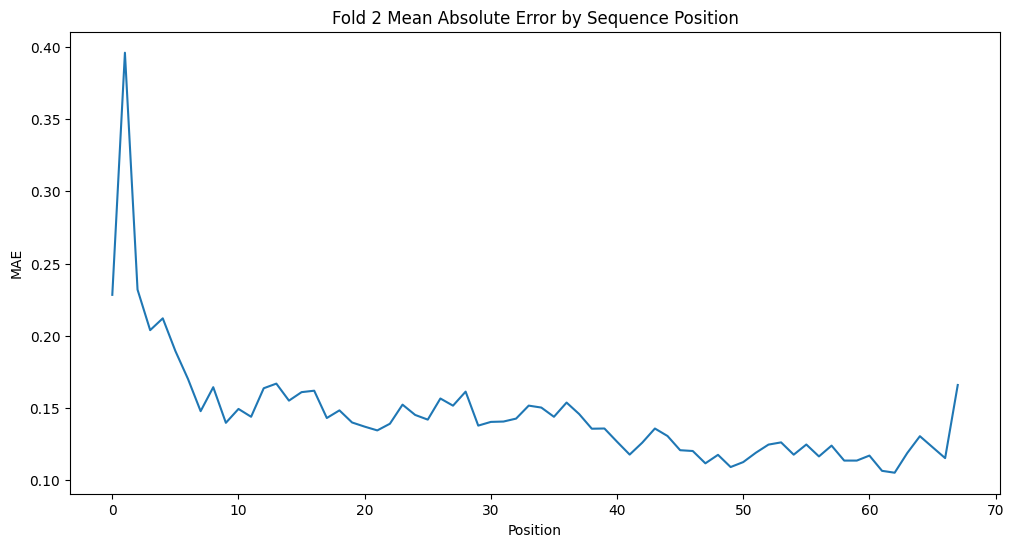

Fold 3 training
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node (InputLayer)              [(None, None, 39)]   0           []                               
                                                                                                  
 adj (InputLayer)               [(None, None, None,  0           []                               
                                 5)]                                                              
                                                                                                  
 model_8 (Functional)           (None, None, 231)    6224006     ['node[0][0]',                   
                                                                  'adj[0][0]']                    
                                                                            

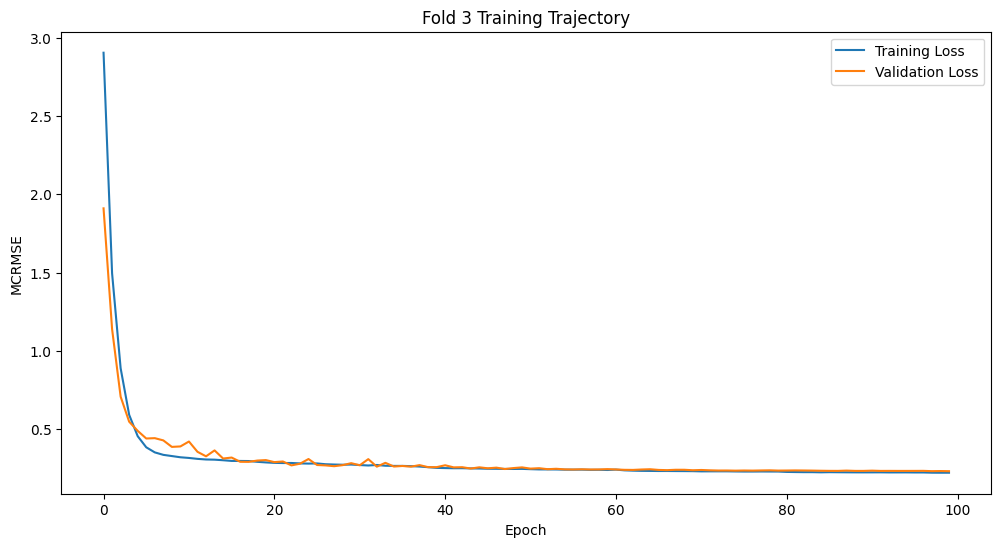

Fold 3: MCRMSE 0.23231920455257002

Validation Metrics:
reactivity_rmse: 0.2103
reactivity_r2: 0.7794
deg_Mg_pH10_rmse: 0.2517
deg_Mg_pH10_r2: 0.7679
deg_pH10_rmse: 0.2531
deg_pH10_r2: 0.8198
deg_Mg_50C_rmse: 0.2162
deg_Mg_50C_r2: 0.8200
deg_50C_rmse: 0.2303
deg_50C_r2: 0.7445


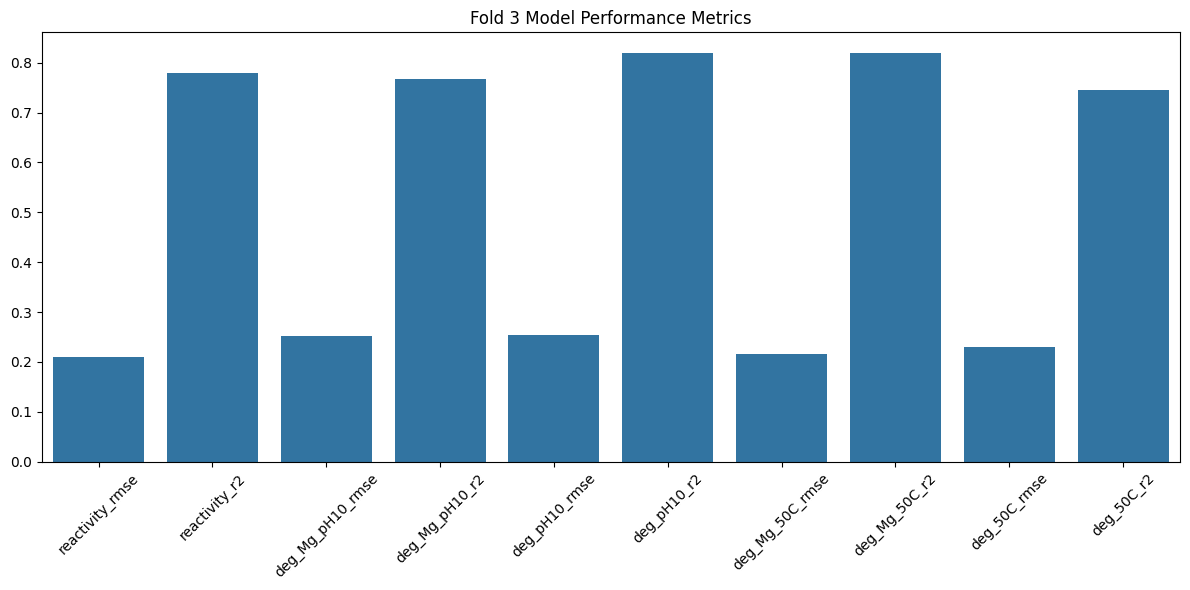

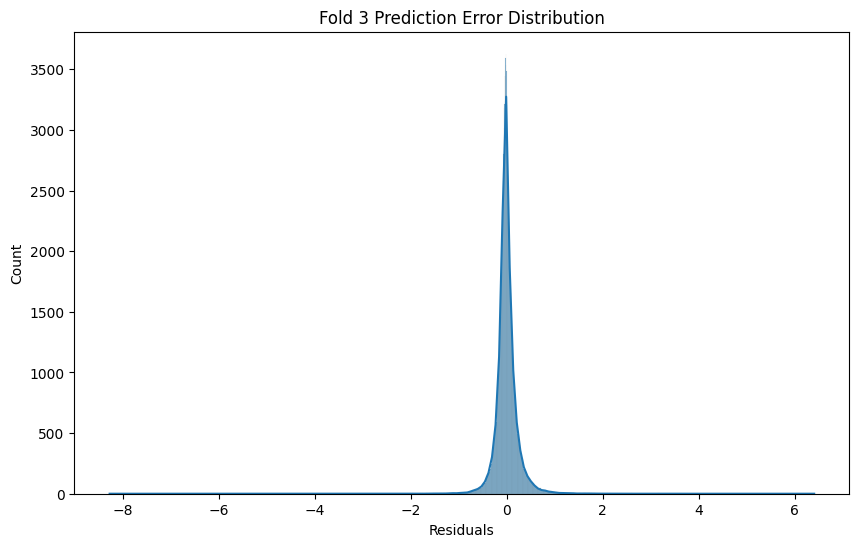

C:\Users\mateu\AppData\Local\Temp\ipykernel_16040\3234836794.py:103: RuntimeWarning: Mean of empty slice
  positional_errors = np.nanmean(np.abs(residuals), axis=(0, 2))


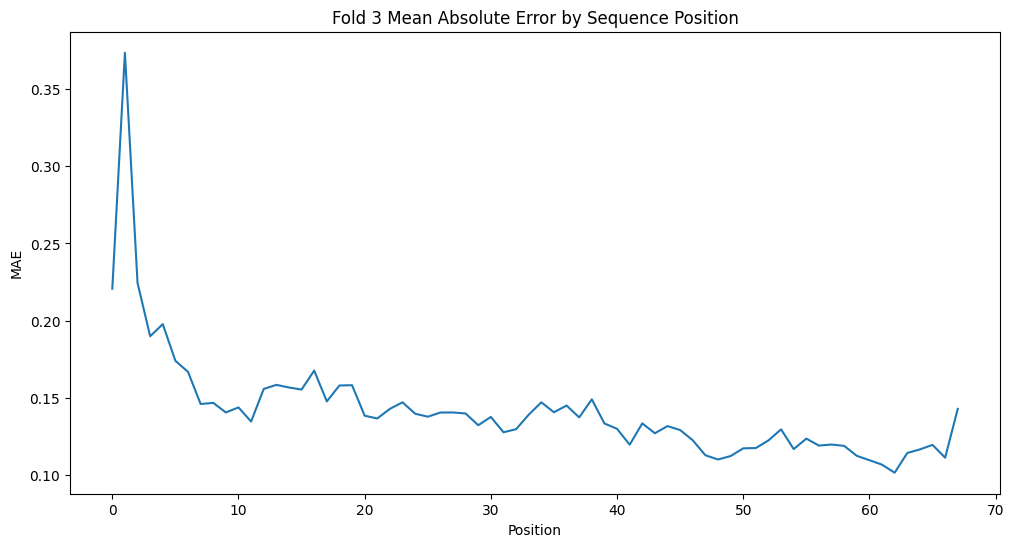

Fold 4 training
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node (InputLayer)              [(None, None, 39)]   0           []                               
                                                                                                  
 adj (InputLayer)               [(None, None, None,  0           []                               
                                 5)]                                                              
                                                                                                  
 model_10 (Functional)          (None, None, 231)    6224006     ['node[0][0]',                   
                                                                  'adj[0][0]']                    
                                                                           

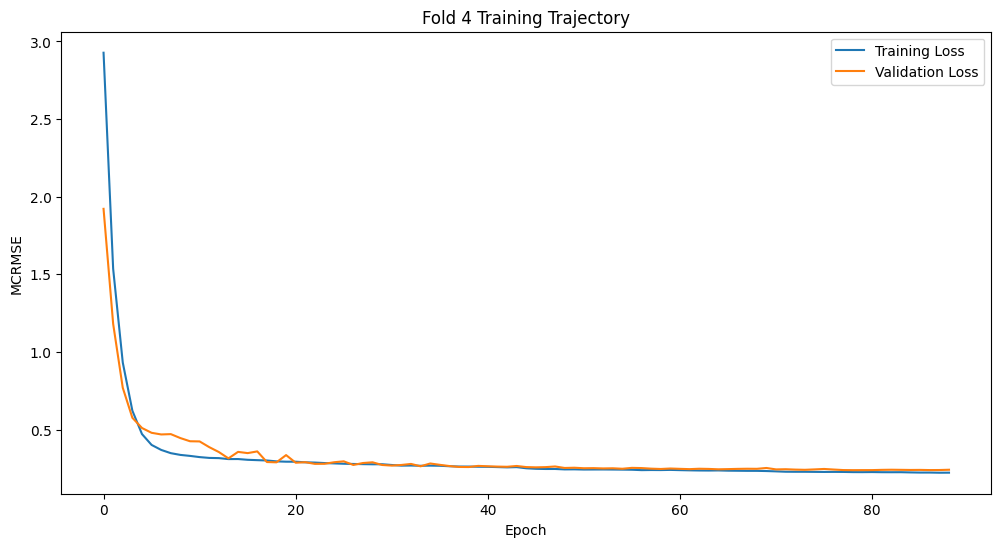

Fold 4: MCRMSE 0.236422750217898

Validation Metrics:
reactivity_rmse: 0.2102
reactivity_r2: 0.7809
deg_Mg_pH10_rmse: 0.2510
deg_Mg_pH10_r2: 0.7637
deg_pH10_rmse: 0.2600
deg_pH10_r2: 0.8175
deg_Mg_50C_rmse: 0.2232
deg_Mg_50C_r2: 0.8105
deg_50C_rmse: 0.2377
deg_50C_r2: 0.7404


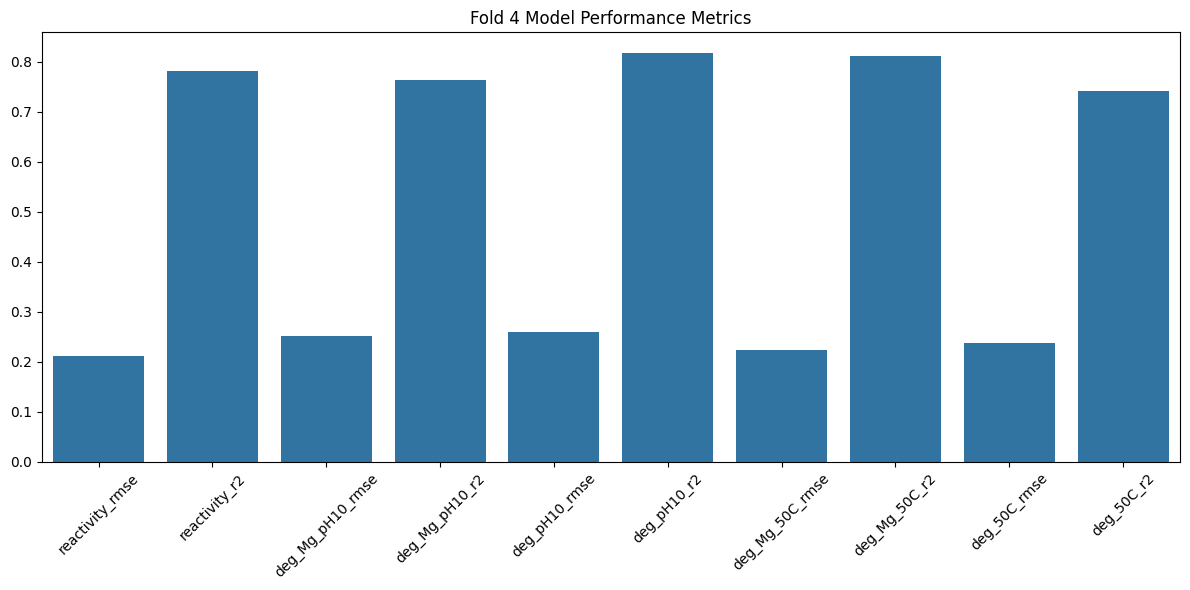

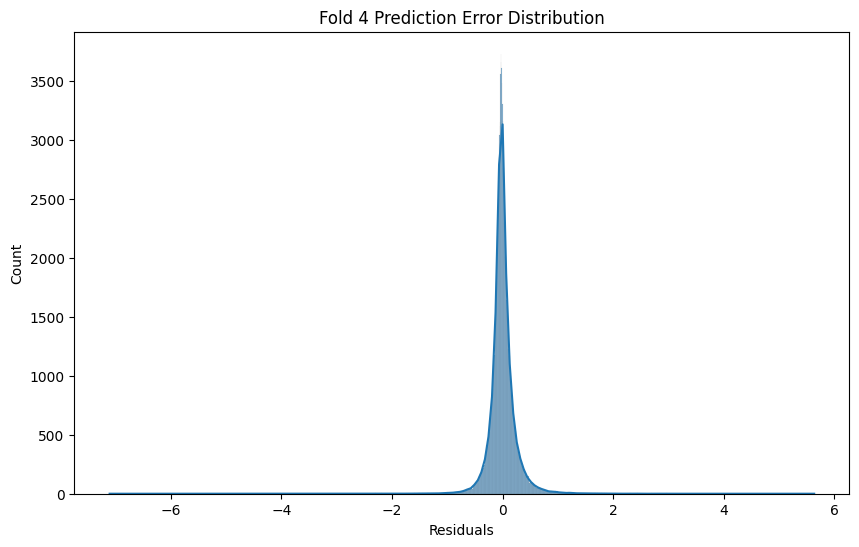

C:\Users\mateu\AppData\Local\Temp\ipykernel_16040\3234836794.py:103: RuntimeWarning: Mean of empty slice
  positional_errors = np.nanmean(np.abs(residuals), axis=(0, 2))


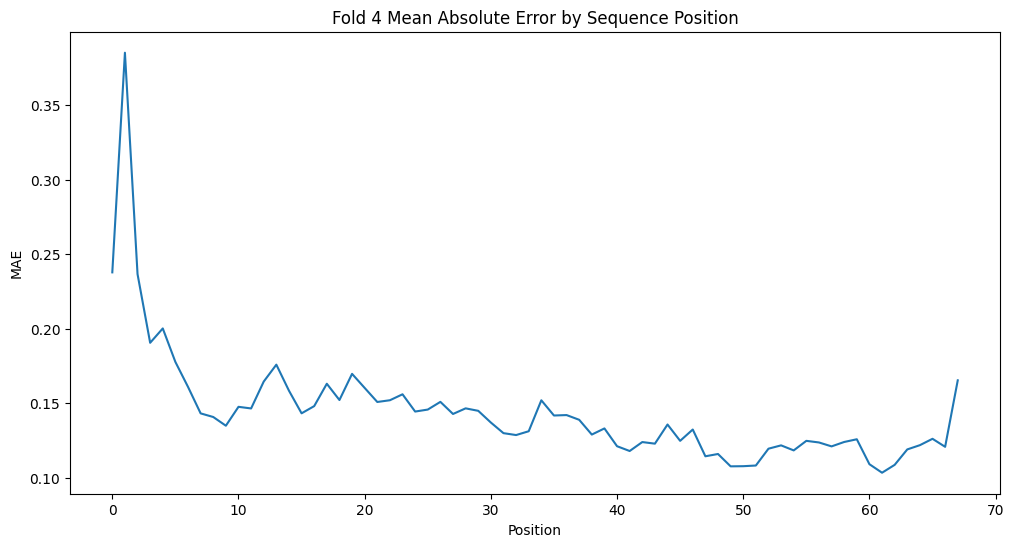


Cross-Validation Results
Individual Fold MCRMSE Scores: [0.23817530064887552, 0.24122247299328814, 0.23850023215084554, 0.23231920455257002, 0.236422750217898]
Mean MCRMSE across all folds: 0.23732799211269545


In [13]:
kfold = KFold(5, shuffle=True, random_state=22)
scores = []
preds_oof = np.zeros([len(X_node), X_node.shape[1], len(targets)])
p_pub_total = np.zeros([len(X_node_pub), X_node_pub.shape[1], len(targets)])
p_pri_total = np.zeros([len(X_node_pri), X_node_pri.shape[1], len(targets)])

for fold, (tr_idx, va_idx) in enumerate(kfold.split(X_node, As)):
    print(f"Fold {fold} training")

    # Data split
    X_node_tr, X_node_va = X_node[tr_idx], X_node[va_idx]
    As_tr, As_va = As[tr_idx], As[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    # Model initialization
    base_model_fold = get_base(X_node.shape[2], As.shape[3])
    base_model_fold.load_weights("./weights/base_ae.weights.h5")
    model = get_model(base_model_fold, seq_len_target_example, As.shape[3])

    # Visualize architecture
    print(model.summary())

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=5, min_lr=0.00001, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
        ),
    ]

    # Training
    history = model.fit(
        [X_node_tr, As_tr],
        [y_tr],
        validation_data=([X_node_va, As_va], [y_va]),
        epochs=100,
        batch_size=64,
        callbacks=callbacks,
        verbose=1,
    )

    # Save model
    model.save_weights(f"./weights/model{fold}.weights.h5")

    # Training Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"Fold {fold} Training Trajectory")
    plt.ylabel("MCRMSE")
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig(f"./images/fold_{fold}_loss_curve.png", bbox_inches="tight")
    plt.show()

    # Evaluation
    p_fold_val = model.predict([X_node_va, As_va])
    fold_mcrmse = mcrmse(y_va, p_fold_val, seq_len_target_example)
    scores.append(fold_mcrmse)
    print(f"Fold {fold}: MCRMSE {scores[-1]}")

    # Performance metrics
    def calculate_metrics(y_true, y_pred):
        metrics = {}
        for i, target in enumerate(targets):
            t = y_true[:, :, i].flatten()
            p = y_pred[:, :, i].flatten()
            valid_idx = t != ignore_value
            t = t[valid_idx]
            p = p[valid_idx]
            metrics[f"{target}_rmse"] = np.sqrt(mean_squared_error(t, p))
            metrics[f"{target}_r2"] = r2_score(t, p)
        return metrics

    val_metrics = calculate_metrics(y_va, p_fold_val)
    print("\nValidation Metrics:")
    for k, v in val_metrics.items():
        print(f"{k}: {v:.4f}")

    # Metric visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(val_metrics.keys()), y=list(val_metrics.values()))
    plt.title(f"Fold {fold} Model Performance Metrics")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"./images/fold_{fold}_metrics.png", bbox_inches="tight")
    plt.show()

    # Error analysis
    residuals = y_va - p_fold_val
    valid_mask = y_va != ignore_value
    residuals[~valid_mask] = np.nan

    plt.figure(figsize=(10, 6))
    sns.histplot(residuals[valid_mask].flatten(), kde=True)
    plt.title(f"Fold {fold} Prediction Error Distribution")
    plt.xlabel("Residuals")
    plt.savefig(f"./images/fold_{fold}_error_dist.png", bbox_inches="tight")
    plt.show()

    positional_errors = np.nanmean(np.abs(residuals), axis=(0, 2))
    plt.figure(figsize=(12, 6))
    plt.plot(positional_errors)
    plt.title(f"Fold {fold} Mean Absolute Error by Sequence Position")
    plt.xlabel("Position")
    plt.ylabel("MAE")
    plt.savefig(f"./images/fold_{fold}_positional_errors.png", bbox_inches="tight")
    plt.show()

    # Store predictions
    preds_oof[va_idx] = p_fold_val
    p_pub_total += model.predict([X_node_pub, As_pub])
    p_pri_total += model.predict([X_node_pri, As_pri])

    del X_node_tr, X_node_va, As_tr, As_va, y_tr, y_va, base_model_fold, model
    gc.collect()

# Average predictions
p_pub_total /= kfold.n_splits
p_pri_total /= kfold.n_splits

# Save OOF predictions
pd.to_pickle(preds_oof, "oof.pkl")

print("\nCross-Validation Results")
print("Individual Fold MCRMSE Scores:", scores)
print("Mean MCRMSE across all folds:", np.mean(scores))

# Submission Generation


In [14]:
preds_ls = []
# Process public test set
for i, uid in enumerate(test_pub.id):
    single_pred = p_pub_total[i]
    single_df = pd.DataFrame(
        single_pred[:, : test_pub["seq_scored"].iloc[i]], columns=targets
    )
    single_df["id_seqpos"] = [f"{uid}_{x}" for x in range(single_df.shape[0])]
    preds_ls.append(single_df)

# Process private test set
for i, uid in enumerate(test_pri.id):
    single_pred = p_pri_total[i]
    single_df = pd.DataFrame(
        single_pred[:, : test_pri["seq_scored"].iloc[i]], columns=targets
    )
    single_df["id_seqpos"] = [f"{uid}_{x}" for x in range(single_df.shape[0])]
    preds_ls.append(single_df)

# Create submission
preds_df = pd.concat(preds_ls)
preds_df.to_csv("submission.csv", index=False)

preds_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.707173,0.684580,1.801182,0.565262,0.732751,id_00073f8be_0
1,2.519086,3.478836,4.812572,3.457462,2.967022,id_00073f8be_1
2,1.468085,0.616005,0.747239,0.754934,0.802840,id_00073f8be_2
3,1.375845,1.252349,1.305949,1.685984,1.556370,id_00073f8be_3
4,0.891406,0.652722,0.720812,0.904750,0.907841,id_00073f8be_4
